Author: Jane Liu

Date: Sep 13th, 2019

Email: jane06172019@gmail.com

## Backgroud and questions:


In [66]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math  


# Some assumptions:

1) To easily calculate each week's demand increase, assume there are 4 weeks each month;

2) For the calculation process below, we look at monthly customer increase and monthly customer stop serving in a weekly perspective. That is, each week the demand is the same for all customers, and each month the customer number is the same for 4 weeks of that month;

3) For Question 1, assume that the increase rate is for the next 6 months and each week in the current month the demand remain the same;

4) For Question 2, assume the monthly storage could be considered as normal distribution since we use Monte Carlos method to repeat the process 5000 times and the Law of Large Numbers states as such, then use the confidence interval of normal distribution to calculate 90% and 99% lower bound; 

5) For Question 2, assume the storage could be negative meaning shortage;

6) For Question 2, assume each restaurant’s demand weekly increase is the same and it means the increase of average demand is the same, and the total weekly demand equal to weekly customer number times average weekly demand per customer;

7) For Question 2, assume the product current produced could be directly sold and transferred to customers when the storage reach the maximum: 3 million;

8) For Question 2, to calculate the exact month I use the number of weeks whose storage is negative minus 1 then divide 4 to find the corresponding month. For instance, if week 13's storage is negative, the corresponding month to add a second production line should be: (13 - 1) / 4 = 3. We round down to the floor integer.



# (1) How will our sales grow over the next 6 months in the 10th, 50th, and 90th percentile cases?

### Totally increase 10%, 50%, 90% over 6 months

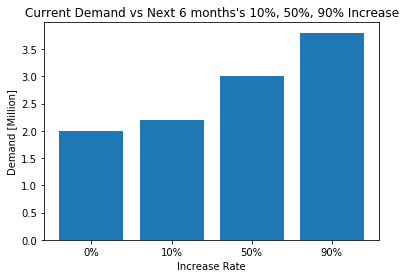

In [67]:
# set up initial sale demand
initial_customer = 10000

initial_demand_each_customer_week = 50

initial_storage = 1000000

initial_demand = initial_customer * initial_demand_each_customer_week * 4



# calculate the increase sale with 10th, 50th, 90th in the next 6 months

next6month_demand_0 = initial_demand / 1000000

next6month_demand_10 = initial_demand * (1 + 0.1) / 1000000

next6month_demand_50 = initial_demand * (1 + 0.5) / 1000000

next6month_demand_90 = initial_demand * (1 + 0.9) / 1000000

# Build two lists for data visualization

next6month_rate = [next6month_demand_0, next6month_demand_10, next6month_demand_50, next6month_demand_90]

col = ['0%', '10%', '50%', '90%']


plt.bar(col, next6month_rate)
plt.ylabel('Demand [Million]')
plt.xlabel('Increase Rate')
plt.title('Current Demand vs Next 6 months\'s 10%, 50%, 90% Increase')
plt.show()

In [68]:
print('10% increase rate: ',next6month_demand_10, '\n50% increase rate: ', next6month_demand_50,'\n90% increase rate: ', next6month_demand_90)

10% increase rate:  2.2 
50% increase rate:  3.0 
90% increase rate:  3.8


# (2) When do we need to complete construction on the second line in order to be 90% sure that we will not have a shortage in the next 18 months? 99% sure?

### Build a function to compute weekly customer numbers using two uniform distributions: monthly customer increase and monthly customer stop serving rate

In [69]:
def Customer_Number_Week(add_customer_month, left_customer_month):
    
    customer_number_each_week = initial_customer
    
    customer_each_week_list = []
    
    for i, j in zip(add_customer_month, left_customer_month):
        
        customer_number_each_week = customer_number_each_week * (1 - j) + i
        
        for _ in range(4):
            
            customer_each_week_list.append(customer_number_each_week)
            
    return customer_each_week_list

### Build functions to calculate the weekly demand, weekly supply and weekly storage

In [70]:
# weekly supply, demand and storage function

def Supply_Demand_Storage_List(customer_number_each_week, add_demand_each_week, production_each_week):
    
    storage_week = initial_storage
    
    storage_max = 3000000
    
    demand_week = initial_demand_each_customer_week

    demand_total_week_list = []
    
    supply_week_list = []
    
    storage_week_list = []

    for i, j, k in zip(customer_number_each_week, add_demand_each_week, production_each_week):

        # assume each restaurant's demand increase is the same
        
        demand_week = demand_week * (1 + j)
        
        demand_total_week = demand_week * i
        
        demand_total_week_list.append(demand_total_week)

        supply_week = (storage_week + k)
        
        supply_week_list.append(supply_week)

        storage_week = min((storage_week + k - demand_total_week), storage_max)

        storage_week_list.append(storage_week)
        
    item = {}
    
    item['demand_total_week_list'] = demand_total_week_list
    
    item['supply_week_list'] = supply_week_list
    
    item['storage_week_list'] = storage_week_list
    
    return item

In [71]:
# build Monte Carlo simulation iteration_number = 5000 times

iteration_number = 5000

demand_next18month_list = []

supply_next18month_list = []

storage_next18month_list = []

n = 18

for i in range(iteration_number):
      
    # generate n months' increase and stop serving customer numbers
       
    add_customer_month= np.random.uniform(200, 1000, n)
    
    left_customer_month= np.random.uniform(0.005, 0.01, n)
    
    # generate n * 4 weeks' add demand and production product
    
    add_demand_each_week= np.random.uniform(0, 0.025, n * 4 )
    
    production_each_week = np.random.uniform(1000000, 1500000, n * 4)
    
    # get weekly customer numbers
    
    customer_number_week = Customer_Number_Week(add_customer_month, left_customer_month)
    
    # calculate 18 month demand, supply and storage
    
    one_iteration = Supply_Demand_Storage_List(customer_number_week, add_demand_each_week, production_each_week)
    
    demand_next18month_list.append(one_iteration['demand_total_week_list'])
    
    supply_next18month_list.append(one_iteration['supply_week_list'])
    
    storage_next18month_list.append(one_iteration['storage_week_list'])

# calculat the mean, st of demand, supply and storage
demand_arr = np.array(demand_next18month_list)

demand_mu = demand_arr.mean(0)

demand_st = demand_arr.std(0)

supply_arr = np.array(supply_next18month_list)

supply_mu = supply_arr.mean(0)

supply_st = supply_arr.std(0)

storage_arr = np.array(storage_next18month_list)

storage_mu = storage_arr.mean(0)

storage_st = storage_arr.std(0)

    
print(demand_mu, '\n\n', supply_mu,'\n\n',  storage_mu)

[ 532852.19935158  539433.24298164  546128.37936898  552922.45711253
  587920.20016676  595285.29145372  602717.88935243  610139.28269584
  646786.26040862  654977.53240048  663261.19421157  671575.05421042
  710252.57634148  719226.72624166  728040.51498375  737048.54371118
  777588.90245983  787271.47907184  797009.35889741  806990.98851989
  849460.28934091  860051.78665519  870836.12848458  881758.20256089
  926458.7054108   938141.85926926  949788.48332026  961590.75236982
 1009433.58115753 1022076.50466599 1034685.56322485 1047696.22771991
 1097944.04761997 1111630.07399268 1125462.43688138 1139471.37494113
 1192485.3164816  1207228.52083057 1222505.2405416  1237813.2815655
 1293756.30192482 1309984.09062656 1326244.49781893 1342713.82126992
 1402162.60787034 1419809.91226058 1437738.51055847 1455672.0392925
 1517794.31608893 1536696.64093422 1556176.29239346 1575842.18170964
 1641586.68308565 1662402.3223352  1682974.44602626 1703998.55315802
 1772720.12156618 1795077.25672087 1

### Use average value to find the shortage

In [72]:
# make a dataframe

Week = np.arange(1, 73)

# change units to millions

demand_mu_M = demand_mu / 1000000

supply_mu_M = supply_mu / 1000000

storage_mu_M  = storage_mu / 1000000

df = pd.DataFrame({'Week': Week, 'Demand_Mean': demand_mu_M, 'Supply_Mean':supply_mu_M, 'Storage_Mean': storage_mu_M})

# change dataframe into tidy data

long = pd.melt(df, 'Week')

long.head()

,Week,variable,value
0,1,Demand_Mean,0.532852
1,2,Demand_Mean,0.539433
2,3,Demand_Mean,0.546128
3,4,Demand_Mean,0.552922
4,5,Demand_Mean,0.587920


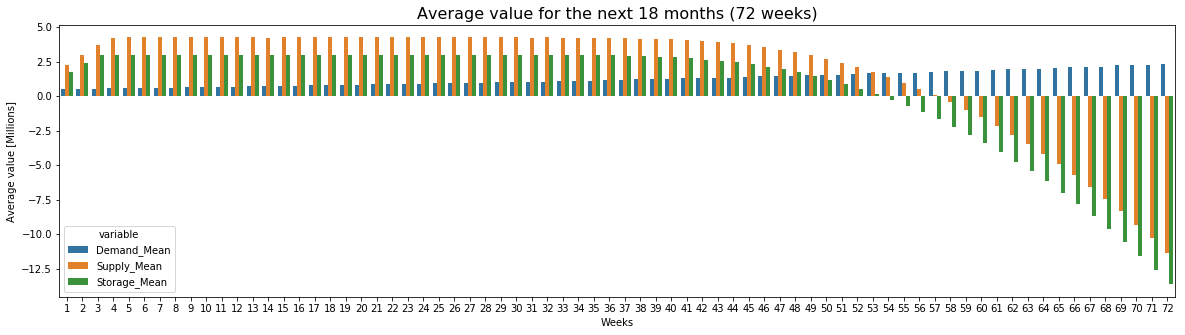

In [73]:
# make plot for weekly supply, demand and storage

fig, ax = plt.subplots(figsize = (20 , 5))
sns.barplot(x = 'Week', y = 'value', hue = 'variable', data = long, ax = ax)
ax.set(xlabel = 'Weeks', ylabel = 'Average value [Millions]')
ax.set_title('Average value for the next 18 months (72 weeks)', fontsize = 16)
plt.show()

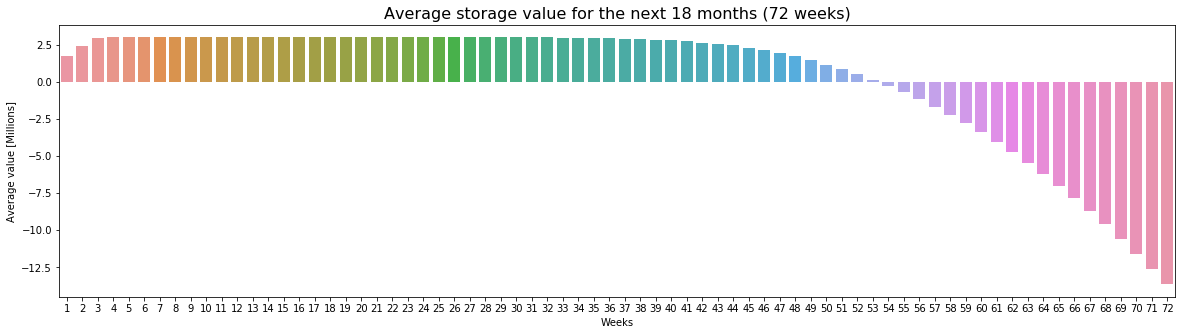

In [74]:
# check the storage plot

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x= 'Week', y = 'Storage_Mean',data = df, ax = ax)
ax.set(xlabel = 'Weeks', ylabel = 'Average value [Millions]')
ax.set_title('Average storage value for the next 18 months (72 weeks)', fontsize = 16)
plt.show()

In [75]:
# find the outage occurrance week and month!

j = 0

for i in storage_mu:
    
    j += 1
    
    if i < 0:
        break
        
print('Conclusion: The %dth week of storage is likely to be the first negative number and it means that the\
 %dth month we would need a second production line.' % (j, int((j - 1) / 4)))

Conclusion: The 54th week of storage is likely to be the first negative number and it means that the 13th month we would need a second production line.


### Use 90%  and 99% Confident Interval to find the outage!

In [76]:
# build the 90% lower bound confidence interval

sqrt_n = math.sqrt(iteration_number)

storage_mu_90 = storage_mu - 1.64 * storage_st / sqrt_n

# change units to millions

storage_mu_90_M = storage_mu_90 / 1000000

storage_mu_90_M

array([  1.71313369,   2.4235749 ,   2.94681579,   2.99987058,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   2.99999963,   3.        ,   2.9999753 ,
         2.99983349,   2.99974261,   2.99951507,   2.9992695 ,
         2.99695587,   2.99541368,   2.99291218,   2.99070689,
         2.9812637 ,   2.97226701,   2.96201556,   2.94958165,
         2.91691403,   2.88578971,   2.84782076,   2.80688918,
         2.72734777,   2.64066304,   2.54819842,   2.44124376,
         2.28003953,   2.1027543 ,   1.91147321,   1.70240619,
         1.43140454,   1.14281501,   0.83324877,   0.50107426,
         0.10652107,  -0.30893245,  -0.74342933,  -1.202567  ,
        -1.72738757,  -2.27670068,  -2.84563331,  -3.44290442,
        -4.10983274,  -4.79826715,  -5.51226441,  -6.24

In [77]:
# build the 99% lower bound confidence interval

sqrt_n = math.sqrt(iteration_number)

storage_mu_99 = storage_mu - 2.58 * storage_st / sqrt_n

# change units to millions

storage_mu_99_M = storage_mu_99 / 1000000

storage_mu_99_M

array([  1.71119387,   2.42081117,   2.94547038,   2.99983624,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   2.99999949,   3.        ,   2.99996661,
         2.99980339,   2.99969569,   2.99945031,   2.99917707,
         2.99676916,   2.99514062,   2.99255117,   2.9902664 ,
         2.98061193,   2.97137543,   2.96089304,   2.94819308,
         2.91503788,   2.88345008,   2.84492498,   2.80341141,
         2.72306786,   2.63551753,   2.5421018 ,   2.43416968,
         2.27181028,   2.09336265,   1.90084407,   1.69051464,
         1.41819438,   1.12828004,   0.81732063,   0.48374414,
         0.08774956,  -0.32916328,  -0.76516208,  -1.22582664,
        -1.75222272,  -2.30315043,  -2.87378642,  -3.4727516 ,
        -4.1414424 ,  -4.83171031,  -5.54756803,  -6.28

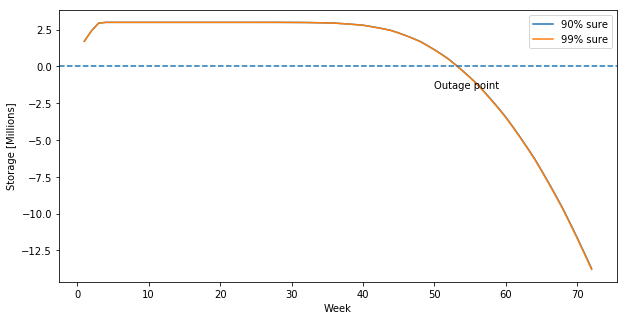

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Week, storage_mu_90_M, label="90% sure")
ax.plot(Week, storage_mu_99_M, label="99% sure")
ax.legend()
plt.ylabel('Storage [Millions]')
plt.xlabel('Week')
plt.axhline(0, ls='--')
plt.text(50, -1.5, "Outage point")
plt.show()

In [79]:
# build data frame for visualization

Week = np.arange(1, 73)
df = {'Week': Week, '90%_sure': storage_mu_90_M, '99%_sure':storage_mu_99_M }
col = ['Week', '90%_sure', '99%_sure']
df = pd.DataFrame(df, columns = col)
long = pd.melt(df, 'Week')
long.head()

,Week,variable,value
0,1,90%_sure,1.713134
1,2,90%_sure,2.423575
2,3,90%_sure,2.946816
3,4,90%_sure,2.999871
4,5,90%_sure,3.000000


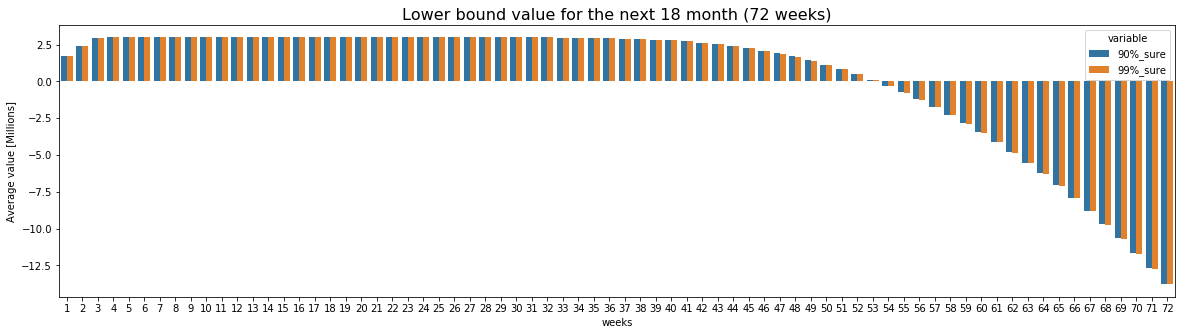

In [83]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x= 'Week', y = 'value', hue= 'variable',data = long, ax = ax)
ax.set(xlabel='weeks', ylabel='Average value [Millions]')
ax.set_title('Lower bound value for the next 18 month (72 weeks)', fontsize =16)
plt.show()

In [81]:
# find the outage occurrance week and month!

j = 0

for i in storage_mu_90_M:
    
    j += 1
    
    if i < 0:
        break
        
print('Conclusion: We are 90%% sure that the %dth week of storage is likely to be the first negative number and it means that the\
 %dth month we would need a second production line.' % (j, int((j - 1) / 4)))

Conclusion: We are 90% sure that the 54th week of storage is likely to be the first negative number and it means that the 13th month we would need a second production line.


In [82]:
# find the outage occurrance week and month!

j = 0

for i in storage_mu_99_M:
    
    j += 1
    
    if i < 0:
        break
print('Conclusion: We are 99%% sure that the %dth week of storage is likely to be the first negative number and it means that the\
 %dth month we would need a second production line.' % (j, int((j - 1) / 4)))

Conclusion: We are 99% sure that the 54th week of storage is likely to be the first negative number and it means that the 13th month we would need a second production line.
